In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch
import matplotlib.patches as patches
from collections import Counter
import matplotlib.patheffects as path_effects

import matplotlib.cm as cm
import matplotlib.colors as mcolors

from highlight_text import ax_text, fig_text
from PIL import Image
from mplsoccer import add_image
import urllib
from urllib.request import urlopen

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("D:\FData\Euro2024\GS+RO16.csv")

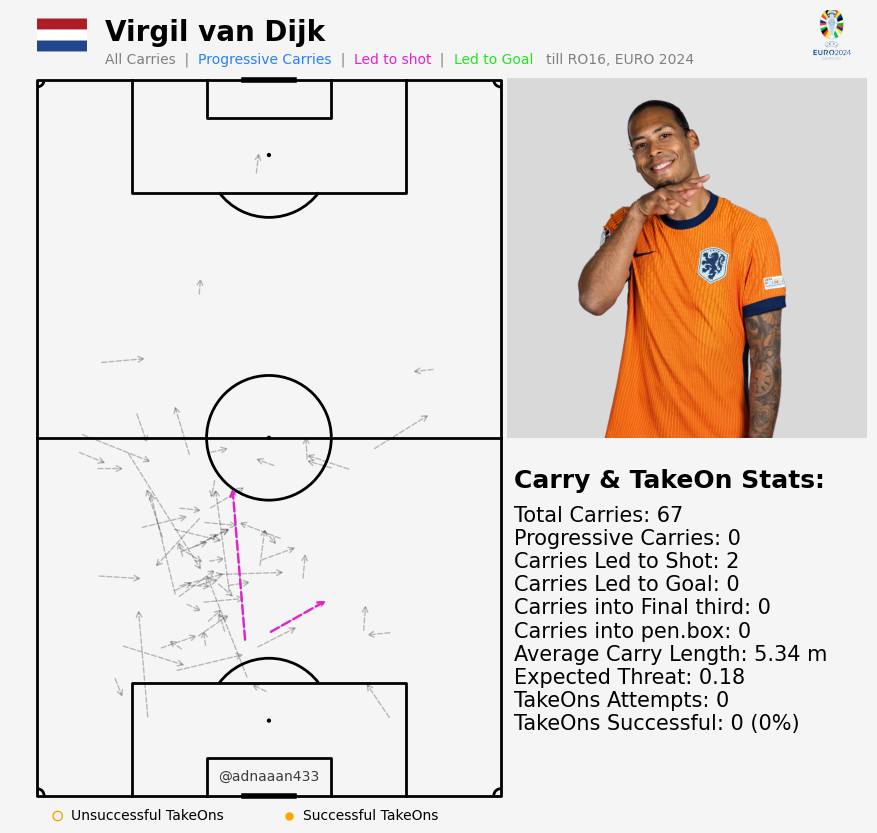

In [53]:
def carry_dribble(ax,pname):
    df_carry = df[(df['type']=='Carry') & (df['name']==pname)]
    led_shot1 = df[(df['type']=='Carry') & (df['name']==pname) & (df['qualifiers'].shift(-1).str.contains('KeyPass'))]
    led_shot2 = df[(df['type']=='Carry') & (df['name']==pname) & (df['type'].shift(-1).str.contains('Shot'))]
    led_shot = pd.concat([led_shot1, led_shot2])
    led_goal1 = df[(df['type']=='Carry') & (df['name']==pname) & (df['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist'))]
    led_goal2 = df[(df['type']=='Carry') & (df['name']==pname) & (df['type'].shift(-1)=='Goal')]
    led_goal = pd.concat([led_goal1, led_goal2])
    pro_carry = df_carry[(df_carry['prog_carry']>=9.11) & (df_carry['x']>=35)]
    fth_carry = df_carry[(df_carry['x']<70) & (df_carry['endX']>=70)]
    box_entry = df_carry[(df_carry['endX']>=88.5) & (df_carry['endY']>=13.6) & (df_carry['endY']<=54.4) &
                 ~((df_carry['x']>=88.5) & (df_carry['y']>=13.6) & (df_carry['y']<=54.6))]
    df_to = df[(df['type']=='TakeOn') & (df['name']==pname)]
    to_sc = df_to[df_to['outcomeType']=='Successful']
    xT = df_carry['xT'].sum().round(2)
    df_carry = df_carry.copy()
    df_carry.loc[:, 'Length'] = np.sqrt((df_carry['x'] - df_carry['endX'])**2 + (df_carry['y'] - df_carry['endY'])**2)
    median_length = round(df_carry['Length'].median(),2)
    if len(df_to)!=0:
        success_rate = round((len(to_sc)/len(df_to))*100, 2)
    else:
        success_rate = 0

    pitch = VerticalPitch(pitch_type='uefa', pitch_color='#f5f5f5', line_color='k', corner_arcs=True, linewidth=2)
    pitch.draw(ax=ax)

    for index, row in df_carry.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->', linestyle='--',
                                        color='k', zorder=1, mutation_scale=10, alpha=0.25, linewidth=1)
        ax.add_patch(arrow)
    for index, row in pro_carry.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->', linestyle='--',
                                        color='#2680ff', zorder=2, mutation_scale=10, alpha=1, linewidth=1.5)
        ax.add_patch(arrow)
    for index, row in led_shot.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->', linestyle='--',
                                        color='#e322cc', zorder=3, mutation_scale=10, alpha=1, linewidth=1.75)
        ax.add_patch(arrow)
    for index, row in led_goal.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), arrowstyle='->', linestyle='--',
                                        color='#25e322', zorder=4, mutation_scale=10, alpha=1, linewidth=1.85)
        ax.add_patch(arrow)

    ax.scatter(df_to.y, df_to.x, color='None', edgecolor='orange', s=45)
    ax.scatter(to_sc.y, to_sc.x, color='orange', edgecolor='#f5f5f5', s=50)
    ax.scatter(65, -3, color='None', edgecolor='orange', s=45)
    ax.scatter(31, -3, color='orange', edgecolor='#f5f5f5', s=50)
    ax.text(63, -3, 'Unsuccessful TakeOns', va='center')
    ax.text(29, -3, 'Successful TakeOns', va='center')
    
    ax.text(58, 112, f'{pname}', fontsize=20, fontweight='bold', ha='left', va='center')
    ax_text(58, 108, s='All Carries  |  <Progressive Carries>  |  <Led to shot>  |  <Led to Goal>   till RO16, EURO 2024', ha='left', va='center', color='#808080',
            highlight_textprops=[{'color':'#2680ff'},{'color':'#e322cc'},{'color':'#25e322'},], ax=ax)
    ax.text(-2, 48, 'Carry & TakeOn Stats:', fontsize=18, fontweight='bold', ha='left', va='top')
    ax.text(-2,46, f'''
Total Carries: {len(df_carry)}
Progressive Carries: {len(pro_carry)}
Carries Led to Shot: {len(led_shot)}
Carries Led to Goal: {len(led_goal)}
Carries into Final third: {len(fth_carry)}
Carries into pen.box: {len(box_entry)}
Average Carry Length: {median_length} m
Expected Threat: {xT}
TakeOns Attempts: {len(df_to)}
TakeOns Successful: {len(to_sc)} ({success_rate}%)''', ha='left', va='top', fontsize=15)

    ax.text(34, 2.75, '@adnaaan433', ha='center', va='center', alpha=0.75)

    team_name = df_carry['teamName'].unique()
    team_name = team_name[0]
    # Take data coordinates and transform them to normalized figure coordinates
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    
    ax_coords = DC_to_NFC((68,108))
    ax_size = 0.05
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    fotmob_url = f'https://raw.githubusercontent.com/adnaaan433/club_teams_logos/main/{team_name}.png'
    fotmob_url = fotmob_url.replace(' ', '%20')
    club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    image_ax.imshow(club_icon)
    image_ax.axis('off')

    ax_coords = DC_to_NFC((-1,52.5))
    ax_size = 0.36
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='#d9d9d9', anchor='C')
    fotmob_url = f'file:///D:/FData/Euro2024/Player_Img/{pname}.html'
    fotmob_url = fotmob_url.replace(' ', '_')
    club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    image_ax.imshow(club_icon)
    image_ax.axis('on')
    image_ax.set_xticks([])
    image_ax.set_yticks([])
    for spine in image_ax.spines.values():
        spine.set_visible(False)

    ax_coords = DC_to_NFC((-45,108))
    ax_size = 0.05
    image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
    fotmob_url = f'https://raw.githubusercontent.com/adnaaan433/league_logos/main/EURO2024.png'
    fotmob_url = fotmob_url.replace(' ', '%20')
    club_icon = Image.open(urllib.request.urlopen(fotmob_url))
    image_ax.imshow(club_icon)
    image_ax.axis('off')
    
    return

fig,ax=plt.subplots(figsize=(10,10), facecolor='#f5f5f5')
carry_dribble(ax, 'Virgil van Dijk')

In [19]:
fwds = df[df['position'] == 'DC']
unique_names = fwds['name'].unique()
sorted_names = sorted(unique_names)
print(sorted_names)

['Abdülkerim Bardakci', 'Alessandro Bastoni', 'Andreas Christensen', 'Andrei Burca', 'Antonio Rüdiger', 'António Silva', 'Arlind Ajeti', 'Attila Fiola', 'Attila Szalai', 'Aymeric Laporte', 'Bartosz Salamon', 'Berat Djimsiti', 'Dani Vivian', 'Danilo Pereira', 'Dayot Upamecano', 'Denis Vavro', 'Endre Botka', 'Fabian Schär', 'Gernot Trauner', 'Gianluca Mancini', 'Giorgi Gvelesiani', 'Gonçalo Inácio', 'Grant Hanley', 'Guram Kashia', 'Illia Zabarnyi', 'Jack Hendry', 'Jaka Bijol', 'Jakub Kiwior', 'Jan Bednarek', 'Jan Vertonghen', 'Jannik Vestergaard', 'Joachim Andersen', 'John Stones', 'Jonathan Tah', 'Josip Sutalo', 'Josko Gvardiol', 'Kaan Ayhan', 'Kevin Danso', 'Kieran Tierney', 'Ladislav Krejcí', 'Lasha Dvali', 'Manuel Akanji', 'Marc Guéhi', 'Marin Pongracic', 'Matteo Darmian', 'Max Wöber', 'Merih Demiral', 'Milan Skriniar', 'Milos Veljkovic', 'Mykola Matviienko', 'Márton Dárdai', 'Nacho', 'Nico Schlotterbeck', 'Nikola Milenkovic', 'Nuno Mendes', 'Oleksandr Svatok', 'Pawel Dawidowicz', 'P

In [ ]:
def carry_stats_counter(pname):
    df_carry = df[(df['type']=='Carry') & (df['name']==pname)]
    led_shot1 = df[(df['type']=='Carry') & (df['name']==pname) & (df['qualifiers'].shift(-1).str.contains('KeyPass'))]
    led_shot2 = df[(df['type']=='Carry') & (df['name']==pname) & (df['type'].shift(-1).str.contains('Shot'))]
    led_shot = pd.concat([led_shot1, led_shot2])
    led_goal1 = df[(df['type']=='Carry') & (df['name']==pname) & (df['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist'))]
    led_goal2 = df[(df['type']=='Carry') & (df['name']==pname) & (df['type'].shift(-1)=='Goal')]
    led_goal = pd.concat([led_goal1, led_goal2])
    pro_carry = df_carry[(df_carry['prog_carry']>=9.11) & (df_carry['x']>=35)]
    fth_carry = df_carry[(df_carry['x']<70) & (df_carry['endX']>=70)]
    box_entry = df_carry[(df_carry['endX']>=88.5) & (df_carry['endY']>=13.6) & (df_carry['endY']<=54.4) &
                 ~((df_carry['x']>=88.5) & (df_carry['y']>=13.6) & (df_carry['y']<=54.6))]
    df_to = df[(df['type']=='TakeOn') & (df['name']==pname)]
    to_sc = df_to[df_to['outcomeType']=='Successful']
    if len(df_to)!=0:
        success_rate = round((len(to_sc)/len(df_to))*100, 2)
    else:
        success_rate = 0
    xT = df_carry['xT'].sum().round(2)
    df_carry = df_carry.copy()
    df_carry.loc[:, 'Length'] = np.sqrt((df_carry['x'] - df_carry['endX'])**2 + (df_carry['y'] - df_carry['endY'])**2)
    median_length = round(df_carry['Length'].median(),2)
    
    Total_Carry = len(df_carry)
    Pro_Carry = len(pro_carry)
    Carry_to_Shot = len(led_shot)
    Carry_to_Goal = len(led_goal)
    Carry_to_fth = len(fth_carry)
    Carry_to_pen = len(box_entry)
    median_Carry_length = median_length
    xT_count = df_carry['xT'].sum().round(2)
    TakeOns = len(df_to)
    Succ_TakeOns = len(to_sc)
    TakeOn_succ_rate = success_rate
    
    return {
        'Total Carries': Total_Carry,
        'Progressive Carries': Pro_Carry,
        'Led to Shot': Carry_to_Shot,
        'Led to Goal': Carry_to_Goal,
        'Carries into Final third': Carry_to_fth,
        'Carries into Penalty Box': Carry_to_pen,
        'Average Carrry Length': median_Carry_length,
        'xT From Carry': xT_count,
        'TakeOns Attempts': TakeOns,
        'TakeOns Successful': Succ_TakeOns
    }

# pnames = ['Álvaro Morata', 'Joselu', 'Georges Mikautadze', 'Kai Havertz', 'Rasmus Højlund', 
#           'Cristiano Ronaldo', 'Benjamin Sesko', 'Marcus Thuram', 'Romelu Lukaku',
#           'Denis Dragus', 'Memphis Depay', 'Marko Arnautovic', 'Kwadwo Duah', 
#           'Baris Alper Yilmaz', 'Harry Kane', 'Róbert Bozeník', 'Gianluca Scamacca']  # Replace with your actual list of player names
pnames = sorted_names

# Create a list of dictionaries to store the counts for each player
data = []

for pname in pnames:
    counts = carry_stats_counter(pname)
    counts['Name'] = pname
    data.append(counts)

# Convert the list of dictionaries to a DataFrame
counts_df = pd.DataFrame(data)

# Sort the DataFrame by 'pr_count' in descending order
carry_counts_df = counts_df.sort_values(by='Progressive Carries', ascending=False)

carry_counts_df.head(20)

In [ ]:
def passing_stats_counter(pname):
    dfpass = df[(df['type']=='Pass') & (df['name']==pname)]
    acc_pass = dfpass[dfpass['outcomeType']=='Successful']
    accurate_pass_perc = round((len(acc_pass)/len(dfpass))*100, 2)
    pro_pass = acc_pass[(acc_pass['prog_pass']>=9.11) & (acc_pass['x']>=35) &
                        (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    Thr_ball = dfpass[(dfpass['qualifiers'].str.contains('Throughball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    Thr_ball_acc = Thr_ball[Thr_ball['outcomeType']=='Successful']
    Lng_ball = dfpass[(dfpass['qualifiers'].str.contains('Longball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    Lng_ball_acc = Lng_ball[Lng_ball['outcomeType']=='Successful']
    Crs_pass = dfpass[(dfpass['qualifiers'].str.contains('Cross')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    Crs_pass_acc = Crs_pass[Crs_pass['outcomeType']=='Successful']

    key_pass = dfpass[dfpass['qualifiers'].str.contains('KeyPass')]
    big_chnc = dfpass[dfpass['qualifiers'].str.contains('BigChanceCreated')]
    df_no_carry = df[df['type']!='Carry']
    df_no_carry = df_no_carry.reset_index(drop=True)
    pre_asst = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist')) & (df_no_carry['type']=='Pass') & (df_no_carry['outcomeType']=='Successful') & 
                  (df_no_carry['name']==pname)]
    assists = dfpass[dfpass['qualifiers'].str.contains('IntentionalGoalAssist')]
    fnl_thd = acc_pass[(acc_pass['endX']>=70) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    pen_box = acc_pass[(acc_pass['endX']>=88.5) & (acc_pass['endY']>=13.6) & (acc_pass['endY']<=54.4) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]

    
    Total_Pass = len(dfpass)
    Accurate_pass = len(acc_pass)
    Accuracy_rate = accurate_pass_perc
    Progressive_pass = len(pro_pass)
    LineB_pass = len(Thr_ball)
    LineB_pass_acc = len(Thr_ball_acc)
    Crs_pass = len(Crs_pass)
    Crs_pass_acc = len(Crs_pass_acc)
    key_pass = len(key_pass)
    big_chnc = len(big_chnc)
    pre_asst = len(pre_asst)
    assists = len(assists)
    fnl_thd = len(fnl_thd)
    pen_box = len(pen_box)
    xT_count = dfpass['xT'].sum().round(2)
    
    return {
        'Total Pass': Total_Pass,
        'Accurate pass': Accurate_pass,
        'Accuracy rate': Accuracy_rate,
        'Progressive pass': Progressive_pass,
        'LineBreaking pass': LineB_pass,
        'LineBreaking pass accuracy': LineB_pass_acc,
        'Cross pass': Crs_pass,
        'key pass': key_pass,
        'big chance': big_chnc,
        'pre assist': pre_asst,
        'assists': assists,
        'Into final third': fnl_thd, 
        'Into Penaly box': pen_box,
        'xT': xT_count
    }

# pnames = ['Álvaro Morata', 'Joselu', 'Georges Mikautadze', 'Kai Havertz', 'Rasmus Højlund', 
#           'Cristiano Ronaldo', 'Benjamin Sesko', 'Marcus Thuram', 'Romelu Lukaku',
#           'Denis Dragus', 'Memphis Depay', 'Marko Arnautovic', 'Kwadwo Duah', 
#           'Baris Alper Yilmaz', 'Harry Kane', 'Róbert Bozeník', 'Gianluca Scamacca']  # Replace with your actual list of player names
pnames = sorted_names

# Create a list of dictionaries to store the counts for each player
data = []

for pname in pnames:
    counts = passing_stats_counter(pname)
    counts['Name'] = pname
    data.append(counts)

# Convert the list of dictionaries to a DataFrame
counts_df = pd.DataFrame(data)

# Sort the DataFrame by 'pr_count' in descending order
passing_counts_df = counts_df.sort_values(by='Progressive pass', ascending=False)

passing_counts_df.head(20)

In [36]:
ball_playing_cb = pd.merge(passing_counts_df, carry_counts_df, on='Name', how='right')

In [37]:
ball_playing_cb['Prog_Pass+Prog_Carry'] = ball_playing_cb['Progressive pass'] + ball_playing_cb['Progressive Carries']

In [ ]:
ball_playing_cb = ball_playing_cb.sort_values(by='Prog_Pass+Prog_Carry', ascending=False)

In [49]:
ball_playing_cb.head(30)

,Total Pass,Accurate pass,Accuracy rate,Progressive pass,LineBreaking pass,LineBreaking pass accuracy,Cross pass,key pass,big chance,pre assist,assists,Into final third,Into Penaly box,xT,Name,Total Carries,Progressive Carries,Led to Shot,Led to Goal,Carries into Final third,Carries into Penalty Box,Average Carrry Length,xT From Carry,TakeOns Attempts,TakeOns Successful,Prog_Pass+Prog_Carry
0,333,306,91.89,30,0,0,1,1,0,0,0,44,1,0.38,Alessandro Bastoni,134,17,0,0,9,0,6.15,0.16,0,0,47
2,300,275,91.67,30,0,0,3,1,0,0,0,37,1,0.59,Rúben Dias,126,14,1,0,5,0,6.14,0.18,1,1,44
32,340,311,91.47,39,2,1,3,2,1,0,0,62,7,0.80,Antonio Rüdiger,104,4,2,0,6,0,4.89,0.05,0,0,43
6,256,221,86.33,30,0,0,8,2,0,0,0,44,1,0.39,Nuno Mendes,83,11,1,0,4,1,5.91,0.16,13,3,41
3,248,229,92.34,26,0,0,2,2,0,1,0,63,2,0.36,Aymeric Laporte,96,13,2,0,6,0,7.19,0.08,0,0,39
20,264,213,80.68,32,0,0,3,0,0,0,0,17,1,0.32,Denis Vavro,96,5,2,0,5,0,6.00,0.07,1,0,37
21,272,246,90.44,32,1,0,0,0,0,0,0,26,3,0.37,Stefan de Vrij,96,5,1,0,3,0,6.67,0.13,1,0,37
9,281,257,91.46,28,0,0,0,2,0,0,0,18,1,0.29,Milan Skriniar,109,8,3,0,2,0,6.37,0.28,3,1,36
11,299,249,83.28,26,0,0,5,2,0,0,0,37,2,0.57,Joachim Andersen,89,8,1,0,1,0,5.98,0.07,1,0,34
47,336,312,92.86,31,0,0,0,1,0,0,1,23,2,0.44,Marc Guéhi,118,2,0,0,0,0,5.94,0.05,1,0,33
